In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.core.pybullet_core import PybulletCore
from src.utils import *
import pybullet as p
import pinocchio as pin
import crocoddyl
from time import sleep

pybullet build time: Nov 29 2025 20:21:24


# Open Pybullet GUI

In [2]:
pb = PybulletCore()
#pb.connect(robot_name = "indy7_v2", joint_limit=True, constraint_visualization = False)
#pb.connect(robot_name = "franka_panda",joint_limit=True, constraint_visualization = False)
pb.connect(robot_name = "franka_panda_handle",joint_limit=True, constraint_visualization = False)


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 5060 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 580.95.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 580.95.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 5060 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
controller init q: [[0. 0. 0. 0. 0. 0. 0.]]
******** ROBOT INFO ********
Robot name: franka_panda_handle
Robot type: fran

In [3]:
## Panda
pb.MoveRobot([0, -45, 0, -135, 0, 90, 45], degree=True, verbose=True)
from time import sleep
sleep(1)

***** Set desired joint angle *****
[ 0.     -0.7854  0.     -2.3562  0.      1.5708  0.7854]


In [2]:
import pybullet as p
import numpy as np
import time
from IPython.display import clear_output

# 1. 로봇 및 시뮬레이션 초기화 (이미 되어 있다면 생략 가능)
# pb = PybulletCore()
# pb.connect(robot_name="franka_panda_handle", joint_limit=True, constraint_visualization=False)

# 로봇 객체 가져오기 (User의 PybulletCore 구현에 따라 pb.my_robot 혹은 pb.robot 등으로 접근)
# 여기서는 pb 내부에 robot 변수가 있다고 가정합니다. 
robot = pb.my_robot 
robot_id = robot.robotId
client_id = robot.ClientId

# 센서가 달려있는 조인트 인덱스와 실제 힘을 가할 링크 인덱스 확인
# 보통 FT 센서는 손목 조인트에 있고, 힘은 그보다 말단(EE)에 가해야 센서가 값을 읽습니다.
ft_sensor_joint_idx = robot.RobotFTJointIdx[0] 
ee_link_idx = robot.RobotEEJointIdx[0]

print(f"FT Sensor Joint Index: {ft_sensor_joint_idx}")
print(f"Force Applied Link Index: {ee_link_idx}")

# ==========================================
# 실험 설정: 특정 방향으로 힘을 가해봅니다.
# ==========================================
APPLIED_FORCE = [0, 0, 15.0]  # x, y, z [N] (Body Frame 기준, Z축으로 20N 당기기)
DURATION = 2.0                # 2초 동안 힘 인가

# 시뮬레이션 루프
print("Starting Force Injection Experiment...")
start_time = time.time()

# 데이터 수집용 리스트
ft_data_log = []

while True:
    current_time = time.time()
    elapsed = current_time - start_time
    
    if elapsed > DURATION:
        break
    
    # ---------------------------------------------------------
    # 1. 가상의 외력 인가 (PyBullet 기능)
    # ---------------------------------------------------------
    # flags=p.LINK_FRAME : 로봇의 EE 좌표계 기준으로 힘을 줍니다. (직관적 확인 용이)
    # flags=p.WORLD_FRAME: 월드 좌표계 기준으로 힘을 줍니다.
    p.applyExternalForce(objectUniqueId=robot_id,
                         linkIndex=ee_link_idx,
                         forceObj=APPLIED_FORCE,
                         posObj=[0, 0, 0],      # 힘이 작용하는 위치 (링크 원점 기준)
                         flags=p.LINK_FRAME,    # 로봇 끝단 좌표계 기준
                         physicsClientId=client_id)
    
    # ---------------------------------------------------------
    # 2. 로봇 업데이트 및 시뮬레이션 스텝
    # ---------------------------------------------------------
    #pb._robot_update() # 혹은 robot.robot_update() 등 내부 update 함수 호출
    robot.robot_update()
    # ---------------------------------------------------------
    # 3. 힘 센서 값 읽기
    # ---------------------------------------------------------
    # robot.ft는 (Fx, Fy, Fz, Mx, My, Mz) 6x1 벡터라고 가정
    ft_reading = robot.ft.flatten() 
    ft_data_log.append(ft_reading)
    
    # 디버깅 출력 (너무 빠르면 읽기 힘드니 0.1초마다 출력하거나 마지막에 평균 확인)
    # print(f"Applied: {APPLIED_FORCE} | Measured: {ft_reading[:3]}") 
    
    time.sleep(pb.dt) # Real-time sync (옵션)

# ==========================================
# 결과 분석
# ==========================================
avg_ft = np.mean(ft_data_log, axis=0)

print("\n" + "="*40)
print(" EXPERIMENT RESULTS (Body Frame Force)")
print("="*40)
print(f"1. Applied Force (Body Frame) : {APPLIED_FORCE} N")
print(f"2. Measured Force (F/T Sensor): {np.round(avg_ft[:3], 3)} N")
print(f"3. Measured Torque            : {np.round(avg_ft[3:], 3)} Nm")
print("-" * 40)

# 부호 및 축 확인
print(">> CHECK POINTS:")
if np.abs(avg_ft[2]) > 5.0: # Z축에 유의미한 값이 찍혔다면
    if np.sign(avg_ft[2]) == np.sign(APPLIED_FORCE[2]):
        print("   [SUCCESS] Z-axis Sign Matches! (+)")
    else:
        print("   [WARNING] Z-axis Sign is REVERSED! (-)")
        print("   -> 코드에서 self._ft = -states... 부분을 확인하거나,")
        print("   -> 제어기에서 tau_ext = -J.T @ F 대신 +J.T @ F를 써야 할 수도 있습니다.")
else:
    print("   [ERROR] No significant force detected. Check Link Index.")

pybullet build time: Nov 29 2025 20:21:24


NameError: name 'pb' is not defined

In [6]:
import time

from IPython.display import clear_output

# ==============================================================================
# 🎮 외력 테스트 설정 (Body Frame 기준)
# ==============================================================================
# 1. 힘의 크기 (Newton)
FORCE_MAGNITUDE = 500.0  

# 2. 힘의 방향 (Body Frame 기준 - EE 좌표계)
# [1, 0, 0]: EE 기준 X축 (보통 손가락 옆 방향)
# [0, 1, 0]: EE 기준 Y축 (보통 손가락 닫히는 방향)
# [0, 0, 1]: EE 기준 Z축 (손끝이 가리키는 방향, 찌르기)
FORCE_DIR_LOCAL = [0, -1, 1]  

# 3. 힘을 줄 시간 (초)
DURATION = 5.0 

# ==============================================================================
# 초기화
# ==============================================================================
robot = pb.my_robot
robot_id = robot.robotId
client_id = robot.ClientId

# 인덱스 확인
ft_idx = robot.RobotFTJointIdx[0] if len(robot.RobotFTJointIdx) > 0 else -1
ee_idx = robot.RobotEEJointIdx[0]

print(f"FT Sensor Joint Index: {ft_idx}")
print(f"Force Applied Link Index: {ee_idx}")

# 방향 벡터 정규화
f_dir = np.array(FORCE_DIR_LOCAL)
f_dir = f_dir / np.linalg.norm(f_dir)
applied_force_local = f_dir * FORCE_MAGNITUDE

print(f"Applying Force: {FORCE_MAGNITUDE}N in BODY Dir {FORCE_DIR_LOCAL}")
print("The RED ARROW will ROTATE with the robot hand.")

# 디버그 라인 ID
debug_line_id = -1
last_print_time = 0.0

start_time = time.time()

try:
    while True:
        current_time = time.time()
        elapsed = current_time - start_time
        
        if elapsed > DURATION:
            print("\nTime's up! Force removed.")
            break
            
        # -------------------------------------------------
        # 1. 현재 EE 위치 및 회전 가져오기
        # -------------------------------------------------
        ee_state = p.getLinkState(robot_id, ee_idx)
        ee_pos_world = np.array(ee_state[4]) # 위치 (World)
        ee_orn_world = np.array(ee_state[5]) # 회전 (Quaternion)
        
        # -------------------------------------------------
        # 2. 힘 벡터 시각화 (Local -> World 변환 필요!)
        # -------------------------------------------------
        # 물리 엔진엔 Local로 넣지만, 눈으로 보는 화살표는 World 좌표로 그려야 함
        # Quaternion -> Rotation Matrix 변환
        rot_mat = np.array(p.getMatrixFromQuaternion(ee_orn_world)).reshape(3, 3)
        
        # Local 힘 벡터를 World 방향으로 회전
        force_vec_visual = rot_mat @ applied_force_local
        
        # 화살표 끝점 계산
        line_end_pos = ee_pos_world + force_vec_visual * 0.02
        
        if debug_line_id == -1:
            debug_line_id = p.addUserDebugLine(ee_pos_world, line_end_pos, 
                                               lineColorRGB=[1, 0, 0], 
                                               lineWidth=3, lifeTime=0)
        else:
            p.addUserDebugLine(ee_pos_world, line_end_pos, 
                               lineColorRGB=[1, 0, 0], 
                               lineWidth=3, replaceItemUniqueId=debug_line_id)
            
        # -------------------------------------------------
        # 3. 물리적 힘 인가 (Body Frame)
        # -------------------------------------------------
        p.applyExternalForce(objectUniqueId=robot_id,
                             linkIndex=ee_idx,
                             forceObj=applied_force_local,  # Local 힘 벡터 그대로 사용
                             posObj=[0, 0, 0],              # 힘 작용점 (링크 원점 기준)
                             flags=p.LINK_FRAME)            # [중요] LINK_FRAME 플래그 사용
        
        # -------------------------------------------------
        # 4. 시뮬레이션 및 로봇 업데이트
        # -------------------------------------------------
        robot.robot_update() 
        time.sleep(pb.dt)

        # -------------------------------------------------
        # 5. 힘 센서 정보 출력 (디버깅)
        # -------------------------------------------------
        if current_time - last_print_time > 0.2:
            last_print_time = current_time
            
            ft_data = robot.ft.flatten()
            f_meas = ft_data[:3]
            t_meas = ft_data[3:]
            f_mag = np.linalg.norm(f_meas)
            
            clear_output(wait=True) 
            print(f"=== Force Control Debugging (Body Frame) (t={elapsed:.1f}s) ===")
            print(f"[Input]  Applied Force (Local)  : {applied_force_local.round(2)} N")
            print(f"[Sensor] Measured Force (Local) : {f_meas.round(2)} N")
            print(f"         Measured Torque        : {t_meas.round(2)} Nm")
            print(f"         Force Magnitude        : {f_mag:.2f} N")
            print("-" * 50)
            
            # [진단 가이드]
            # 센서도 Local, 입력도 Local이므로, 좌표축(XYZ) 값 자체가 비슷하게 나와야 함
            print(">> CHECK POINTS:")
            diff = np.abs(applied_force_local - f_meas)
            if np.max(diff) < 5.0:
                print("✅  입력된 로컬 힘과 센서 측정값이 축별로 일치합니다.")
            else:
                print("⚠️  축별 값 차이가 큽니다. (좌표계 정의가 다르거나 부호 반대 가능성)")
                print(f"    Diff: {diff.round(2)}")

except KeyboardInterrupt:
    print("Stopped by user.")

finally:
    if debug_line_id != -1:
        p.removeUserDebugItem(debug_line_id)

=== Force Control Debugging (Body Frame) (t=4.8s) ===
[Input]  Applied Force (Local)  : [   0.   -353.55  353.55] N
[Sensor] Measured Force (Local) : [ 12.31 -50.88  -7.17] N
         Measured Torque        : [1.72 0.45 0.01] Nm
         Force Magnitude        : 52.84 N
--------------------------------------------------
>> CHECK POINTS:
⚠️  축별 값 차이가 큽니다. (좌표계 정의가 다르거나 부호 반대 가능성)
    Diff: [ 12.31 302.67 360.72]

Time's up! Force removed.


In [ ]:
import time
from IPython.display import clear_output
# ==============================================================================
# 🎮 외력 테스트 설정 (World Frame 기준)
# ==============================================================================
# 1. 힘의 크기 (Newton)
FORCE_MAGNITUDE = 500.0  

# 2. 힘의 방향 (World Frame 기준)
# [1, 0, 0]: 화면상 X축(빨간축) 방향
# [0, 1, 0]: 화면상 Y축(초록축) 방향 
# [0, 0, 1]: 화면상 Z축(파란축) 방향
FORCE_DIR_WORLD = [0, 0, -1]  

# 3. 힘을 줄 시간 (초)
DURATION = 3 

# ==============================================================================
# 초기화
# ==============================================================================
robot = pb.my_robot
robot_id = robot.robotId
client_id = robot.ClientId

# 센서 조인트 & 힘 가할 링크 인덱스 확인
# (보통 F/T 센서는 관절에 있고, 힘은 링크(Body)에 가함)
# 작성하신 PybulletRobot 클래스 변수 사용
ft_idx = robot.RobotFTJointIdx[0] if len(robot.RobotFTJointIdx) > 0 else -1
ee_idx = robot.RobotEEJointIdx[0]

print(f"FT Sensor Joint Index: {ft_idx}")
print(f"Force Applied Link Index: {ee_idx}")

# 방향 벡터 정규화
f_dir = np.array(FORCE_DIR_WORLD)
f_dir = f_dir / np.linalg.norm(f_dir)
applied_force_world = f_dir * FORCE_MAGNITUDE

print(f"Applying Force: {FORCE_MAGNITUDE}N in WORLD Dir {FORCE_DIR_WORLD}")

# 디버그 라인 ID
debug_line_id = -1
last_print_time = 0.0

start_time = time.time()

try:
    while True:
        current_time = time.time()
        elapsed = current_time - start_time
        
        if elapsed > DURATION:
            print("\nTime's up! Force removed.")
            break
            
        # -------------------------------------------------
        # 1. 현재 EE 위치 가져오기 (World Frame)
        # -------------------------------------------------
        ee_state = p.getLinkState(robot_id, ee_idx)
        ee_pos_world = np.array(ee_state[4]) 
        
        # -------------------------------------------------
        # 2. 힘 벡터 시각화 (빨간 화살표 = 내가 주는 힘)
        # -------------------------------------------------
        line_end_pos = ee_pos_world + applied_force_world * 0.02
        
        if debug_line_id == -1:
            debug_line_id = p.addUserDebugLine(ee_pos_world, line_end_pos, 
                                               lineColorRGB=[1, 0, 0], 
                                               lineWidth=3, lifeTime=0)
        else:
            p.addUserDebugLine(ee_pos_world, line_end_pos, 
                               lineColorRGB=[1, 0, 0], 
                               lineWidth=3, replaceItemUniqueId=debug_line_id)
            
        # -------------------------------------------------
        # 3. 물리적 힘 인가 (World Frame)
        # -------------------------------------------------
        p.applyExternalForce(objectUniqueId=robot_id,
                             linkIndex=ee_idx,
                             forceObj=applied_force_world,
                             posObj=ee_pos_world,
                             flags=p.WORLD_FRAME)
        
        # -------------------------------------------------
        # 4. 시뮬레이션 및 로봇 업데이트
        # -------------------------------------------------
        robot.robot_update() # 여기서 self._ft가 업데이트됨
        time.sleep(pb.dt)

        # -------------------------------------------------
        # 5. [추가된 부분] 힘 센서 정보 출력 (디버깅)
        # -------------------------------------------------
        # 너무 빠르게 출력하면 보기 힘드므로 0.2초마다 갱신
        if current_time - last_print_time > 0.2:
            last_print_time = current_time
            
            # 로봇 내부의 F/T 값 가져오기
            # robot.ft는 (6,1) 행렬이므로 flatten()으로 1차원 배열 변환
            ft_data = robot.ft.flatten()
            f_meas = ft_data[:3] # Force [Fx, Fy, Fz]
            t_meas = ft_data[3:] # Torque [Mx, My, Mz]
            
            # 벡터 크기(Magnitude) 계산
            f_mag = np.linalg.norm(f_meas)
            
            # 출력 (clear_output을 쓰면 애니메이션처럼 한 줄에서 갱신됨)
            clear_output(wait=True) 
            print(f"=== Force Control Debugging (t={elapsed:.1f}s) ===")
            print(f"[Input]  Applied Force (World) : {applied_force_world.round(2)} N")
            print(f"[Sensor] Measured Force (Local) : {f_meas.round(2)} N")
            print(f"         Measured Torque        : {t_meas.round(2)} Nm")
            print(f"         Force Magnitude        : {f_mag:.2f} N")
            print("-" * 50)
            
            # # [진단 가이드]
            # if f_mag < 1.0:
            #     print("⚠️  센서 값이 너무 작습니다. (힘이 제대로 안 들어가거나 센서 인덱스 확인 필요)")
            # elif abs(f_mag - FORCE_MAGNITUDE) > 5.0:
            #     print("⚠️  입력값과 측정값 차이가 큽니다. (마찰, 관성, 또는 좌표계 차이 고려)")
            # else:
            #     print("✅  입력된 힘이 잘 측정되고 있습니다.")

except KeyboardInterrupt:
    print("Stopped by user.")

finally:
    if debug_line_id != -1:
        p.removeUserDebugItem(debug_line_id)

=== Force Control Debugging (t=3.0s) ===
[Input]  Applied Force (World) : [   0.    0. -500.] N
[Sensor] Measured Force (Local) : [-24.84 -34.01  20.97] N
         Measured Torque        : [ 1.3  -0.92 -0.  ] Nm
         Force Magnitude        : 47.04 N
--------------------------------------------------

Time's up! Force removed.


: 

In [4]:
#pb.my_robot.set_control_mode("idc") 
#pb.my_robot.set_control_mode("peg_imp") 
pb.my_robot.set_control_mode("imp") 
#pb.my_robot.set_control_mode("pidc") 

[Controller] Switching mode -> imp
[PybulletRobot] F/T Sensor Calibrated. Bias: [ 0.48   -0.2038  6.0636  0.0096  0.0192 -0.    ]


In [ ]:
# ===== 1) Pinocchio 모델/데이터 가져오기 =====
robot_model = pb.my_robot.pinModel.pinModel   # pinocchio.Model
robot_data  = pb.my_robot.pinModel.pinData    # pinocchio.Data


# 현재 상태 가져오기
q_init_reduced = pb.my_robot.q.reshape(-1)
nq = robot_model.nq
nv = robot_model.nv


# 초기 상태 정의
q0 = q_init_reduced.copy()
v0 = np.zeros(nv)
x0 = np.concatenate([q0, v0])



ee_frame_name = "panda_ee"   

ee_frame_id   = robot_model.getFrameId(ee_frame_name)

print(ee_frame_id)

26


: 

In [ ]:
import pybullet as p

robot_id = pb.my_robot.robotId

print(f"{'Index':<5} | {'Joint Name':<30} | {'Link Name'}")
print("-" * 60)

num_joints = p.getNumJoints(robot_id)
for i in range(num_joints):
    info = p.getJointInfo(robot_id, i)
    # info[1]: Joint Name (bytes), info[12]: Link Name (bytes)
    joint_name = info[1].decode('utf-8')
    link_name  = info[12].decode('utf-8')
    
    print(f"{i:<5} | {joint_name:<30} | {link_name}")

Index | Joint Name                     | Link Name
------------------------------------------------------------
0     | panda_joint1                   | panda_link1
1     | panda_joint2                   | panda_link2
2     | panda_joint3                   | panda_link3
3     | panda_joint4                   | panda_link4
4     | panda_joint5                   | panda_link5
5     | panda_joint6                   | panda_link6
6     | panda_joint7                   | panda_link7
7     | panda_joint8                   | panda_flange
8     | panda_joint9                   | panda_flange_tool
9     | panda_joint10                  | panda_rft44
10    | panda_joint11                  | panda_stick
11    | panda_joint12                  | panda_ee


: 

# Move robot

In [3]:
## Panda
pb.MoveRobot([0, -45, 0, -135, 0, 90, 45], degree=True, verbose=True)
from time import sleep
sleep(1)

***** Set desired joint angle *****
[ 0.     -0.7854  0.     -2.3562  0.      1.5708  0.7854]


In [3]:
#pb.MoveRobot([40, 30, 60, 135, -122, 80], degree=True, verbose=True)
pb.MoveRobot([0, 0, 0, -90, 0, 0, 0], degree=True, verbose=True)
from time import sleep
sleep(3)

***** Set desired joint angle *****
[ 0.      0.      0.     -1.5708  0.      0.      0.    ]


In [12]:
pb.MoveRobot([0, 0, 0, 0, 0, 0, 0], degree=True, verbose=True)
from time import sleep
sleep(3)

***** Set desired joint angle *****
[0. 0. 0. 0. 0. 0. 0.]


# Get PyBullet robot's properties (Current states)

In [ ]:
q = pb.my_robot.q
PRINT_YELLOW("Joint position (rad)", q.T)

qdot = pb.my_robot.qdot
PRINT_YELLOW("Joint velocity (rad/s)", qdot.T) #dq.T

p = pb.my_robot.p
PRINT_YELLOW("End-effector's pose in xyz-xi vector", p.T)

T_end = pb.my_robot.T_end
PRINT_YELLOW("End-effector's pose in SE3\n", T_end)

Jr = pb.my_robot.Jr
PRINT_YELLOW("Robot's jacobian\n", Jr)

g = pb.my_robot.g
PRINT_YELLOW("Gravity compensate term", g.T)


fk_test = pb.my_robot.forward_kinematics
#PRINT_YELLOW("End-effector's pose in SE3_test\n", fk_test(np.deg2rad([40, 30, 60, 135, -122, 80])))
PRINT_YELLOW("End-effector's pose in SE3_test\n", fk_test(np.deg2rad([0, 40, 0, 0, 0, 0, 0])))

Joint position (rad): [[-1.3002 -0.0905  1.2949 -2.3366  0.1151  2.301   0.0441]]
Joint velocity (rad/s): [[ 0.2436 -0.0075 -0.21   -0.0646 -0.1299  0.1953  1.1821]]
End-effector's pose in xyz-xi vector: [[ 0.4999  0.0001  0.256   3.1335 -0.1994 -0.0119]]
End-effector's pose in SE3
: [[ 0.9918 -0.1278 -0.0075  0.4999]
 [-0.1278 -0.9918 -0.0014  0.0001]
 [-0.0073  0.0023 -1.      0.256 ]
 [ 0.      0.      0.      1.    ]]
Robot's jacobian
: [[ 0.      0.9637 -0.0241 -0.0064  0.7374 -0.084  -0.0077]
 [ 0.      0.2671  0.0871 -0.9962 -0.0635 -0.9965 -0.0013]
 [ 1.      0.      0.9959  0.087  -0.6725  0.0019 -1.    ]
 [-0.0635 -0.0288 -0.0693  0.3839 -0.0037  0.1953  0.    ]
 [-0.4959 -0.0713 -0.4912 -0.0832 -0.0869 -0.0084  0.    ]
 [-0.0006  0.1335  0.043  -0.4267 -0.     -0.088   0.    ]]
Gravity compensate term: [[-0.     -3.5318 -1.9874 16.2894  0.6058  1.5252 -0.    ]]
End-effector's pose in SE3_test
: [[ 0.766   0.     -0.6428  0.4486]
 [ 0.     -1.      0.      0.    ]
 [-0.6428  

: 

# FK (Assignment 1)

In [6]:

T_est = pb.my_robot.forward_kinematics(np.deg2rad([88,11,30,-50,4,61]))
PRINT_YELLOW("End-effector's pose in SE3_test\n", T_est)

pb.add_debug_frames(
    [T_est],
    palettes=[ ((0,1,1),(1,0,1),(1,1,0)) ]  
)



End-effector's pose in SE3_test
: [[-0.1665 -0.983  -0.0774  0.1076]
 [ 0.7243 -0.0687 -0.686  -0.5117]
 [ 0.669  -0.1703  0.7235  0.9864]
 [ 0.      0.      0.      1.    ]]


In [7]:
pb.MoveRobot([88,11,30,-50,4,61], degree=True, verbose=True)
from time import sleep
sleep(3)


T_ref = pb.my_robot.T_end
PRINT_YELLOW("End-effector's pose in SE3\n", T_ref)

***** Set desired joint angle *****
[ 1.5359  0.192   0.5236 -0.8727  0.0698  1.0647]
End-effector's pose in SE3
: [[-0.1665 -0.983  -0.0774  0.1076]
 [ 0.7243 -0.0687 -0.686  -0.5117]
 [ 0.669  -0.1703  0.7235  0.9864]
 [ 0.      0.      0.      1.    ]]


In [ ]:

def skew(v):
    x, y, z = v.reshape(3)
    return np.array([[0, -z,  y],
                     [z,  0, -x],
                     [-y, x,  0]], float)

def so3_log(R):
    # returns phi (axis-angle vector), theta
    cosang = (np.trace(R) - 1.0) / 2.0
    cosang = np.clip(cosang, -1.0, 1.0)
    theta = float(np.arccos(cosang))
    if theta < 1e-12:
        return np.zeros(3), 0.0
    phi = np.array([
        R[2,1] - R[1,2],
        R[0,2] - R[2,0],
        R[1,0] - R[0,1]
    ]) * (0.5 / np.sin(theta))
    # phi is unit axis; return axis*theta:
    return phi * theta, theta

def se3_log(T):
    R = T[:3,:3]
    p = T[:3, 3]
    phi, theta = so3_log(R)
    if theta < 1e-12:
        rho = p  # small-angle: V ≈ I
    else:
        W = skew(phi / theta)             # unit axis hat
        V = (np.eye(3)
             + (1 - np.cos(theta))/theta * W
             + (theta - np.sin(theta))/theta * (W @ W))
        rho = np.linalg.solve(V, p)
    xi = np.concatenate([rho, phi])       # 6x1 residual
    return xi, theta

def pose_error(T_est, T_ref):
    # ΔT = T_ref^{-1} T_est
    Rr, pr = T_ref[:3,:3], T_ref[:3,3]
    Re, pe = T_est[:3,:3], T_est[:3,3]
    dR = Rr.T @ Re
    dp = Rr.T @ (pe - pr)   # body-frame dp (월드에서 보고 싶으면 그냥 pe-pr)
    # translational error (in world):
    trans_err = np.linalg.norm(pe - pr)
    # rotational geodesic:
    cosang = (np.trace(dR) - 1.0) / 2.0
    cosang = np.clip(cosang, -1.0, 1.0)
    rot_err_deg = np.degrees(np.arccos(cosang))
    # 6D log residual:
    xi, _ = se3_log(np.block([[dR, dp.reshape(3,1)],
                              [np.zeros((1,3)), np.array([[1.0]])]]))
    return trans_err, rot_err_deg, xi  # xi = [rho(3), phi(3)]


te, re, xi = pose_error(T_est, T_ref)
print(f"[pose error] transl: {te:.4f} m, rot: {re:.3f} deg")
print("xi (se3 log residual) =", np.round(xi, 6))


In [7]:
pb.destroy_debug_frames()

# Rotation & Transformation Matrix Utils

In [8]:
# Euler angle -> Rotation matrix
R = eul2Rot([90, 0, 0], seq='XYZ', degree=True)
print(R)

# Rotation matrix -> Euler angle
eul = Rot2eul(R, seq='XYZ', degree=True)
print(eul)

[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[90.  0.  0.]


In [ ]:
# xyz position + Euler angle -> Transformation matrix
T = xyzeul2SE3([0.2, 0.3, 0.4], [90, 0, 0], seq='XYZ', degree=True)
print(T)

# Transformation matrix -> xyz position + Euler angle
xyz = T[0:3, 3]
eul = Rot2eul(T[0:3, 0:3], seq='XYZ', degree=True)
print(xyz, eul)

# Matrix Exponential/Logarithm (Out of this course!)

In [ ]:
R = eul2Rot([90, 0, 0], seq='XYZ', degree=True)
print(R)

# Rotation matrix -> 3-by-1 vector (log)
xi = Rot2Vec(R)
print(xi)

# 3-by-1 vector -> rotation matrix (exp)
R = Vec2Rot(xi)
print(R)

In [ ]:
T = xyzeul2SE3([0.2, 0.3, 0.4], [90, 0, 0], seq='XYZ', degree=True)
print(T)

# Transformation matrix -> 6-by-1 vector (log)
lamb = SE32Vec(T)
print(lamb)

# 6-by-1 vector -> transformation matrix (exp)
T = Vec2SE3(lamb)
print(T)

# Transformation matrix -> xyz-xi vector (decoupled: position (xyz) and orientation(xi))
xyz_xi = SE32PoseVec(T)
print(xyz_xi)

# xyz-xi vector -> transformation matrix
T = PoseVec2SE3(xyz_xi)
print(T)


xi_ex = np.array([0,     -0.2025,  1.2115,   0,      0,     0])
xi_ex_vec = xi_ex.reshape(6,1)
print(xi_ex_vec)




# IK (Assignment1)

In [63]:
## Indy7
pb.MoveRobot([0, 30, -120, 0, -90, 0], degree=True, verbose=True)
from time import sleep
sleep(1)

Exception in thread Thread-4 (_thread_main):
Traceback (most recent call last):
  File "/home/march-ksj/miniconda3/envs/robot_project/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/march-ksj/miniconda3/envs/robot_project/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/march-ksj/Desktop/MECH439_pybullet_framework/src/core/pybullet_core.py", line 123, in _thread_main
    self.my_robot.robot_update()
  File "/home/march-ksj/Desktop/MECH439_pybullet_framework/src/core/pybullet_robot.py", line 57, in robot_update
    self._compute_torque_input()  # compute applied motor torques
  File "/home/march-ksj/Desktop/MECH439_pybullet_framework/src/core/pybullet_robot.py", line 341, in _compute_torque_input
    qddot = self._qddot_des + Kp * (self._q_des - self._q) + Kd * (self._qdot_des - self._qdot)
ValueError: operands could not be broadcast together with shapes (6,1) (7,1) 


***** Set desired joint angle *****
[ 0.      0.5236 -2.0944  0.     -1.5708  0.    ]


In [19]:
## Panda
pb.MoveRobot([0, 0, 0, -90, 0, 90, 0], degree=True, verbose=True)
from time import sleep
sleep(1)

***** Set desired joint angle *****
[ 0.      0.      0.     -1.5708  0.      1.5708  0.    ]


In [16]:
#T_goal = xyzeul2SE3([0, -0.5, 0.5], [0,-180,0], seq='ZYZ', degree=True)

#T_goal = xyzeul2SE3([0.4, 0.5, 0.5], [0,-180,180], seq='ZYZ', degree=True)

T_goal = xyzeul2SE3([0.4, 0.5, 0.5], [0,-180,0], seq='ZYZ', degree=True)

#T_goal = xyzeul2SE3([0.5, -0.5, 0.5], [0,45,0], seq='ZYZ', degree=True)


pb.add_debug_frames([T_goal])
print(T_goal)




[[-1.  -0.  -0.   0.4]
 [ 0.   1.  -0.   0.5]
 [ 0.   0.  -1.   0.5]
 [ 0.   0.   0.   1. ]]


## 피노키오 사용 -> Joint Space에서 리니어

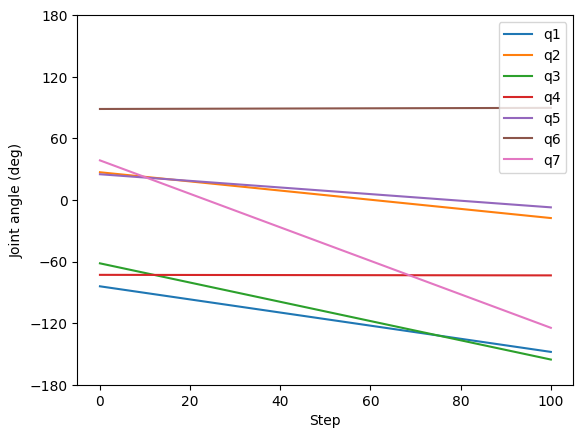

In [17]:
from time import sleep

q_init = pb.my_robot.q             
q_lower = pb.my_robot.q_lower       
q_upper = pb.my_robot.q_upper     


q_sol = pb.my_robot.pinModel.CLIK(
    T_goal,
    ql=q_lower,
    qu=q_upper,
    q_init=q_init,
    N_trials=20,    
)

if q_sol is None:
    print("[IK] CLIK failed to find a solution")
else:

    n = q_init.size
    qlist = np.zeros((n, 0))
    qlist = np.concatenate((qlist, q_init), axis=1)

    n_step = 100
    for k in range(1, n_step + 1):
        alpha = k / n_step
        q_k = (1 - alpha) * q_init + alpha * q_sol
        qlist = np.concatenate((qlist, q_k), axis=1)
        pb.MoveRobot(q_k, degree=False)
        sleep(0.01)

    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.plot(qlist.T * 180 / np.pi)
    plt.legend([f"q{i+1}" for i in range(n)])
    plt.xlabel("Step")
    plt.ylabel("Joint angle (deg)")
    plt.yticks([-180, -120, -60, 0, 60, 120, 180])
    plt.show()



## 피노키오 사용 -> Task Space에서 리니어 + Coupled

[IK] step 53에서 해 못 찾음, 이전 자세 유지
[IK] step 54에서 해 못 찾음, 이전 자세 유지
[IK] step 55에서 해 못 찾음, 이전 자세 유지
[IK] step 56에서 해 못 찾음, 이전 자세 유지
[IK] step 57에서 해 못 찾음, 이전 자세 유지
[IK] step 58에서 해 못 찾음, 이전 자세 유지
[IK] step 59에서 해 못 찾음, 이전 자세 유지
[IK] step 60에서 해 못 찾음, 이전 자세 유지
[IK] step 61에서 해 못 찾음, 이전 자세 유지
[IK] step 62에서 해 못 찾음, 이전 자세 유지
[IK] step 63에서 해 못 찾음, 이전 자세 유지
[IK] step 64에서 해 못 찾음, 이전 자세 유지
[IK] step 65에서 해 못 찾음, 이전 자세 유지
[IK] step 66에서 해 못 찾음, 이전 자세 유지
[IK] step 67에서 해 못 찾음, 이전 자세 유지
[IK] step 68에서 해 못 찾음, 이전 자세 유지
[IK] step 69에서 해 못 찾음, 이전 자세 유지
[IK] step 70에서 해 못 찾음, 이전 자세 유지
[IK] step 71에서 해 못 찾음, 이전 자세 유지
[IK] step 72에서 해 못 찾음, 이전 자세 유지
[IK] step 73에서 해 못 찾음, 이전 자세 유지
[IK] step 74에서 해 못 찾음, 이전 자세 유지
[IK] step 75에서 해 못 찾음, 이전 자세 유지
[IK] step 76에서 해 못 찾음, 이전 자세 유지
[IK] step 77에서 해 못 찾음, 이전 자세 유지
[IK] step 78에서 해 못 찾음, 이전 자세 유지
[IK] step 79에서 해 못 찾음, 이전 자세 유지
[IK] step 80에서 해 못 찾음, 이전 자세 유지
[IK] step 81에서 해 못 찾음, 이전 자세 유지
[IK] step 82에서 해 못 찾음, 이전 자세 유지
[IK] step 83에서 해 못 찾음, 이전 자세 유지
[IK] ste

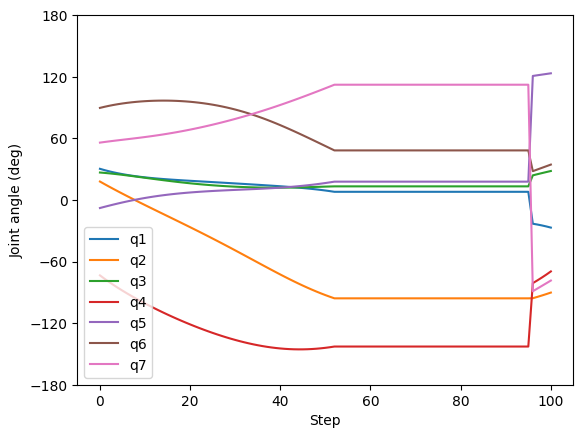

: 

In [ ]:
q_init  = pb.my_robot.q             
q_lower = pb.my_robot.q_lower
q_upper = pb.my_robot.q_upper


T_init = pb.my_robot.pinModel.FK(q_init)   # 4x4 numpy

# 2) numpy → Pinocchio SE3 객체로 변환
T0_se3 = pin.SE3(T_init[0:3, 0:3], T_init[0:3, 3])
Tg_se3 = pin.SE3(T_goal[0:3, 0:3], T_goal[0:3, 3])

# 3) 상대변환의 twist (log6) 구하기: Tg = T0 * exp(xi)
T_rel  = T0_se3.inverse() * Tg_se3     # SE3
xi_hat = pin.log6(T_rel)               # Motion(6): [v; w] in Pinocchio convention

n_step = 100

n = q_init.size
qlist = np.zeros((n, 0))
qlist = np.concatenate((qlist, q_init), axis=1)

q_prev = q_init.copy()

for k in range(1, n_step + 1):
    s = k / n_step   # 0→1

    # 4) task space 상에서 보간된 pose T_s 만들기
    T_s_se3 = T0_se3 * pin.exp6(s * xi_hat)   # exp6(s * xi)
    T_s     = T_s_se3.homogeneous             # 4x4 numpy

    # 5) 각 step마다 IK (CLIK 사용, 직전 q_prev로 warm start)
    q_k = pb.my_robot.pinModel.CLIK(
        T_s,
        ql=q_lower,
        qu=q_upper,
        q_init=q_prev,
        N_trials=1,         # 이미 가까운 q_prev에서 시작하니까 1이면 보통 충분
    )

    if q_k is None:
        print(f"[IK] step {k}에서 해 못 찾음, 이전 자세 유지")
        q_k = q_prev

    q_prev = q_k
    qlist = np.concatenate((qlist, q_k), axis=1)

    pb.MoveRobot(q_k, degree=False)
    sleep(0.01)

# 결과 플롯
fig = plt.figure()
plt.plot(qlist.T * 180 / np.pi)
plt.legend([f"q{i+1}" for i in range(n)])
plt.xlabel("Step")
plt.ylabel("Joint angle (deg)")
plt.yticks([-180, -120, -60, 0, 60, 120, 180])
plt.show()

## 피노키오 사용 -> Task space에서 리니어 + Decoupled

In [196]:
## Panda
pb.MoveRobot([0, 0, 0, -90, 0, 90, 0], degree=True, verbose=True)
from time import sleep
sleep(1)

***** Set desired joint angle *****
[ 0.      0.      0.     -1.5708  0.      1.5708  0.    ]


In [4]:
#T_goal = xyzeul2SE3([0, -0.5, 0.5], [0,-180,0], seq='ZYZ', degree=True)

#T_goal = xyzeul2SE3([0.4, 0.5, 0.5], [0,-180,180], seq='ZYZ', degree=True)

T_goal = xyzeul2SE3([-0.4, 0.5, 0.5], [0,-180,0], seq='ZYZ', degree=True)

#T_goal = xyzeul2SE3([0.5, -0.5, 0.5], [0,45,0], seq='ZYZ', degree=True)


pb.add_debug_frames([T_goal])
print(T_goal)




[[-1.  -0.  -0.  -0.4]
 [ 0.   1.  -0.   0.5]
 [ 0.   0.  -1.   0.5]
 [ 0.   0.   0.   1. ]]


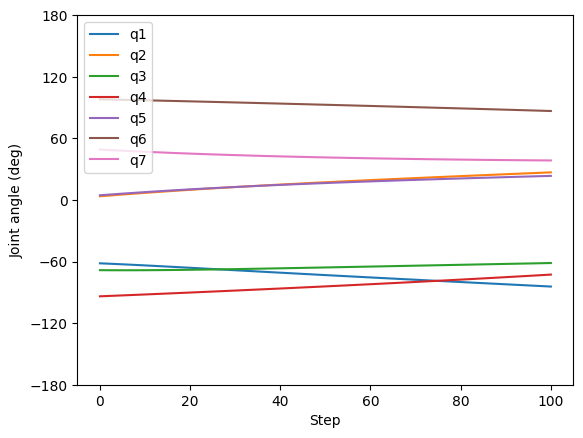

In [14]:
q_init  = pb.my_robot.q              # (n,1)
q_lower = pb.my_robot.q_lower
q_upper = pb.my_robot.q_upper

# FK로 시작 pose 얻기 (4x4 numpy)
T_init = pb.my_robot.pinModel.FK(q_init)

# numpy → Pinocchio SE3로 변환해서 다루기 편하게만 쓰자
T0_se3 = pin.SE3(T_init[0:3, 0:3], T_init[0:3, 3])
Tg_se3 = pin.SE3(T_goal[0:3, 0:3], T_goal[0:3, 3])

R_i = T0_se3.rotation        # 3x3
p_i = T0_se3.translation     # 3,  (pin에서는 1D array)
R_f = Tg_se3.rotation
p_f = Tg_se3.translation

R_rel = R_i.T @ R_f

w = pin.log3(R_rel)      


n_step = 100
n = q_init.size

qlist = np.zeros((n, 0))
qlist = np.concatenate((qlist, q_init), axis=1)

q_prev = q_init.copy()

for k in range(1, n_step + 1):
    s = k / n_step   # 0 → 1


    p_s = (1.0 - s) * p_i + s * p_f        # shape (3,)


    R_s = R_i @ pin.exp3(s * w)           # 3x3


    T_s = np.eye(4)
    T_s[0:3, 0:3] = R_s
    T_s[0:3, 3]   = p_s

    q_k = pb.my_robot.pinModel.CLIK(
        T_s,
        ql=q_lower,
        qu=q_upper,
        q_init=q_prev,
        N_trials=1,        
    )

    if q_k is None:
        print(f"[IK] step {k}에서 해 못 찾음, 이전 자세 유지")
        q_k = q_prev

    q_prev = q_k
    qlist = np.concatenate((qlist, q_k), axis=1)

    pb.MoveRobot(q_k, degree=False)
    sleep(0.01)

# --- joint trajectory plot ---
plt.figure()
plt.plot(qlist.T * 180 / np.pi)
plt.legend([f"q{i+1}" for i in range(n)])
plt.xlabel("Step")
plt.ylabel("Joint angle (deg)")
plt.yticks([-180, -120, -60, 0, 60, 120, 180])
plt.show()

## crocoddyl 테스트
지금 추가해야할 부분: 제어기 수정(예시 참고)
+ 힘 센서 정보 확인
+ hall 추가
+ 힘 제어
+ 

In [6]:
#pb.my_robot.set_control_mode("idc") 
#pb.my_robot.set_control_mode("peg_imp") 
pb.my_robot.set_control_mode("imp") 
#pb.my_robot.set_control_mode("pidc") 

[Controller] Switching mode -> imp
[PybulletRobot] F/T Sensor Calibrated. Bias: [ -31.54    -10.523  -100.5043    0.4839   -1.0264   -0.046 ]


In [3]:
## Panda
pb.MoveRobot([0, -45, 0, -135, 0, 90, 45], degree=True, verbose=True)
from time import sleep
sleep(1)

***** Set desired joint angle *****
[ 0.     -0.7854  0.     -2.3562  0.      1.5708  0.7854]


In [6]:
## Panda
pb.MoveRobot([0, 40, 0, -50, 0, 90, 45], degree=True, verbose=True)
from time import sleep
sleep(1)

T_goal = pb.my_robot.T_end
PRINT_YELLOW("End-effector's pose in SE3\n", T_goal)

***** Set desired joint angle *****
[ 0.      0.6981  0.     -0.8727  0.      1.5708  0.7854]
End-effector's pose in SE3
: [[ 0.8213  0.5654  0.0763  0.5025]
 [ 0.5095 -0.787   0.348   0.4791]
 [ 0.2567 -0.2469 -0.9344  0.6169]
 [ 0.      0.      0.      1.    ]]


In [4]:
#T_goal = xyzeul2SE3([0, -0.5, 0.5], [0,-180,0], seq='ZYZ', degree=True)

#T_goal = xyzeul2SE3([0.4, 0.5, 0.5], [0,-180,180], seq='ZYZ', degree=True)

T_goal = xyzeul2SE3([0.5, 0,0.28], [0,-180, -180], seq='ZYZ', degree=True)


#T_goal = xyzeul2SE3([0.47, 0.025,0.1], [0,-180, -180], seq='ZYZ', degree=True)


pb.add_debug_frames([T_goal])
print(T_goal)




[[ 1.   -0.   -0.    0.5 ]
 [-0.   -1.    0.    0.  ]
 [-0.    0.   -1.    0.28]
 [ 0.    0.    0.    1.  ]]


Solving IK for target pose...
[Success] IK Found solution.
Solver start...
Solver done. Cost: 0.08765630796900271


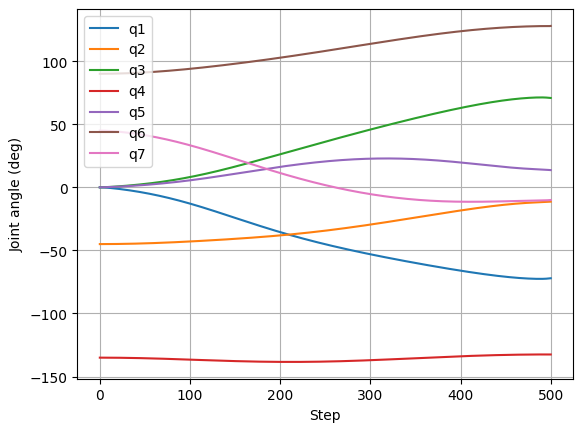

Final Pos Error: 0.124 mm
Final Rot Error: 0.001 deg


In [ ]:
# ===== 1) Pinocchio 모델/데이터 가져오기 =====
robot_model = pb.my_robot.pinModel.pinModel   # pinocchio.Model
robot_data  = pb.my_robot.pinModel.pinData    # pinocchio.Data


# 현재 상태 가져오기
q_init_reduced = pb.my_robot.q.reshape(-1)
nq = robot_model.nq
nv = robot_model.nv


# 초기 상태 정의
q0 = q_init_reduced.copy()
v0 = np.zeros(nv)
x0 = np.concatenate([q0, v0])



ee_frame_name = "panda_ee"   

ee_frame_id   = robot_model.getFrameId(ee_frame_name)

p_f = T_goal[0:3, 3]
R_f = T_goal[0:3, 0:3]
M_goal = pin.SE3(R_f, p_f)


def normalize_angle_diff(q_target, q_current):
    diff = q_target - q_current
    # 차이가 -pi ~ pi 사이에 들어오도록 조정
    diff = (diff + np.pi) % (2 * np.pi) - np.pi
    return q_current + diff


print("Solving IK for target pose...")
q_sol = pb.my_robot.pinModel.CLIK(
    T_goal,
    ql=pb.my_robot.q_lower,
    qu=pb.my_robot.q_upper,
    q_init=q0,       
    N_trials=20,
)

if q_sol is None:
    print("[Error] IK failed! Using q0 as reference (Accuracy will drop).")
    q_ref = q0.copy()
else:
    print("[Success] IK Found solution.")
    q_ref = q_sol.reshape(-1) 
    q_ref = normalize_angle_diff(q_ref, q0)




# ===== 3. Crocoddyl 설정 (xref에 IK 결과 반영) =====

state = crocoddyl.StateMultibody(robot_model)
actuation = crocoddyl.ActuationModelFull(state)
nu = actuation.nu

v_ref = np.zeros(nv)
xref = np.concatenate([q_ref, v_ref])

v_goal = np.zeros(nv)
x_goal_terminal = np.concatenate([q_ref, v_goal])

# --- Cost Models ---
runningCostModel  = crocoddyl.CostModelSum(state, nu)
terminalCostModel = crocoddyl.CostModelSum(state, nu)

# Regularization 
xResidual = crocoddyl.ResidualModelState(state, xref, nu)
xRegCost  = crocoddyl.CostModelResidual(state, xResidual)
uResidual = crocoddyl.ResidualModelControl(state, nu)
uRegCost  = crocoddyl.CostModelResidual(state, uResidual)
xResidualTerminal = crocoddyl.ResidualModelState(state, x_goal_terminal, nu)
#xRegCostTerminal  = crocoddyl.CostModelResidual(state, xResidualTerminal)


runningCostModel.addCost("xReg", xRegCost, 1e-3)
runningCostModel.addCost("uReg", uRegCost, 1e-3)
#terminalCostModel.addCost("xReg", xRegCost, 1e-3)
#terminalCostModel.addCost("xRegStop", xRegCostTerminal, 10.0)

# Goal Tracking (Terminal)
# eeResidual = crocoddyl.ResidualModelFramePlacement(state, ee_frame_id, M_goal, nu)
# eeCost = crocoddyl.CostModelResidual(state, eeResidual)
# terminalCostModel.addCost("eeGoal", eeCost, 1000.0) # 가중치 높임

## 위치랑 Roll방향만 맞출 수 있도록
eeResidual = crocoddyl.ResidualModelFramePlacement(state, ee_frame_id, M_goal, nu)
weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
activation = crocoddyl.ActivationModelWeightedQuad(weights)
eeCost = crocoddyl.CostModelResidual(state, activation, eeResidual)
terminalCostModel.addCost("eeGoal", eeCost, 1000.0)



# ===== 4. Running Model (경로 생성) =====
dt = 0.01
T  = 500
w_ee = 3000.0

# 초기 포즈 계산
pin.forwardKinematics(robot_model, robot_data, q0)
pin.updateFramePlacements(robot_model, robot_data)
M_init = robot_data.oMf[ee_frame_id]
p_i = M_init.translation.copy()
R_i = M_init.rotation.copy()

runningModels = []

for k in range(T):
    # [핵심 수정] 진행률(0~1)을 S-Curve로 변환
    progress = (k + 1) / T
    alpha = 0.5 * (1 - np.cos(np.pi * progress))  # Cosine Interpolation

    # 1. EE Task (Task Space) 보간 (alpha 적용)
    p_ref_k = p_i + alpha * (p_f - p_i)
    
    # 자세 보간 (Slerp)
    M_start = pin.SE3(R_i, p_i)
    M_final = pin.SE3(R_f, p_f)
    M_ref_k = M_start.act(pin.SE3.Interpolate(pin.SE3.Identity(), M_start.actInv(M_final), alpha))

    # 2. Joint Space 가이드 (xReg) 보간 (alpha 적용)
    # 목표에 가까워질수록 alpha 변화량이 줄어들어 천천히 움직이게 됨
    q_guide_k = (1 - alpha) * q0 + alpha * q_ref
    v_guide_k = np.zeros(nv) # 가이드 속도는 0
    xref_k    = np.concatenate([q_guide_k, v_guide_k])

    # --- Cost Model ---
    runningCost_k = crocoddyl.CostModelSum(state, nu)

    # xReg: 부드러운 가이드라인을 따라가도록 유도
    xResidual_k = crocoddyl.ResidualModelState(state, xref_k, nu)
    xRegCost_k  = crocoddyl.CostModelResidual(state, xResidual_k)
    runningCost_k.addCost("xReg", xRegCost_k, 1e-3)

    # uReg: 부드러운 움직임을 위해 적절히 유지
    runningCost_k.addCost("uReg", uRegCost, 1e-4)

    # EE Track: 목표 궤적 추종
    eePlacementResidual_k = crocoddyl.ResidualModelFramePlacement(state, ee_frame_id, M_ref_k, nu)
    eePlacementCost_k = crocoddyl.CostModelResidual(state, eePlacementResidual_k)
    runningCost_k.addCost("eeTrack", eePlacementCost_k, w_ee)

    # Model 추가
    diffModelRunning_k = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCost_k)
    runningModel_k = crocoddyl.IntegratedActionModelEuler(diffModelRunning_k, dt)
    runningModels.append(runningModel_k)


# ===== 5. Solver 실행 =====
diffModelTerminal = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel)
terminalModel = crocoddyl.IntegratedActionModelEuler(diffModelTerminal, 0.)

problem = crocoddyl.ShootingProblem(x0, runningModels, terminalModel)
solver  = crocoddyl.SolverDDP(problem)

xs_init = [x0.copy() for _ in range(T+1)]
us_init = [np.zeros(nu) for _ in range(T)]

print("Solver start...")
solver.solve(xs_init, us_init, maxiter=200)
print(f"Solver done. Cost: {solver.cost}")



# ===== 6. 실행 및 시각화 =====
xs = solver.xs 
qlist = np.zeros((nq, 0))

for x in xs:
    q = x[:nq]
    qlist = np.concatenate((qlist, q.reshape(-1,1)), axis=1)
    pb.MoveRobot(q.reshape(-1,1), degree=False)
    sleep(dt)

# 결과 그래프
plt.figure()
plt.plot(qlist.T * 180/np.pi)
plt.xlabel("Step")
plt.ylabel("Joint angle (deg)")
plt.legend([f"q{i+1}" for i in range(nq)])
plt.grid(True)
plt.show()

# 최종 오차 확인
final_q = xs[-1][:nq]
pin.forwardKinematics(robot_model, robot_data, final_q)
pin.updateFramePlacements(robot_model, robot_data)
final_M = robot_data.oMf[ee_frame_id]
err_vec = pin.log(final_M.actInv(M_goal)).vector
print(f"Final Pos Error: {np.linalg.norm(err_vec[:3])*1000:.3f} mm")
print(f"Final Rot Error: {np.linalg.norm(err_vec[3:])*180/np.pi:.3f} deg")





In [12]:
pb.destroy_debug_frames()

## 원형 트레젝토리

In [3]:
## Panda
pb.MoveRobot([0, -45, 0, -135, 0, 90, 45], degree=True, verbose=True)
from time import sleep
sleep(1)

***** Set desired joint angle *****
[ 0.     -0.7854  0.     -2.3562  0.      1.5708  0.7854]


Start EE position: [0.3069 0.     0.5018]
Drawing circular reference trajectory...
Solving DDP...
DDP done. Final cost: 0.1056999377025588
Executing trajectory...


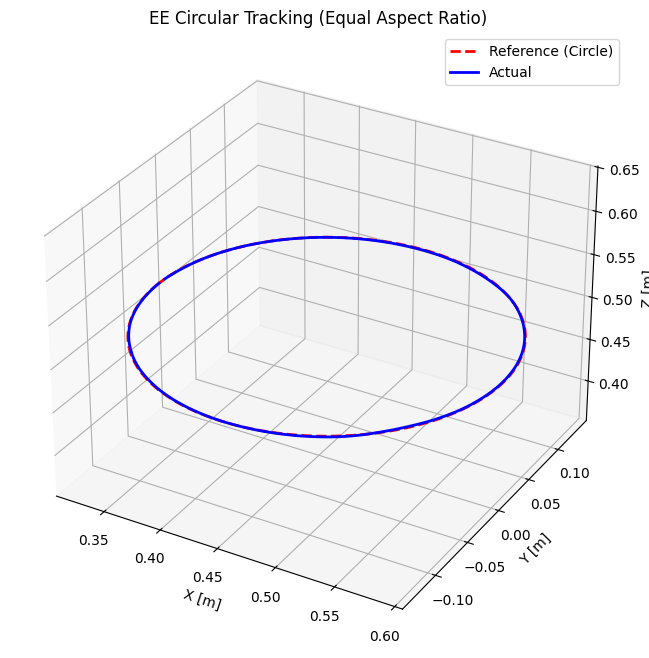

Final Pos Error (Sim): 7.5315 mm


In [4]:

# ==============================================================================
# 1) Pinocchio model / data 가져오기
# ==============================================================================
robot_model = pb.my_robot.pinModel.pinModel   
robot_data  = pb.my_robot.pinModel.pinData    

# 현재 joint 상태
q0 = pb.my_robot.q.reshape(-1)          
nq = robot_model.nq
nv = robot_model.nv
v0 = np.zeros(nv)
x0 = np.concatenate([q0, v0])

# EE frame
ee_frame_name = "panda_ee"
ee_frame_id   = robot_model.getFrameId(ee_frame_name)

# 현재 EE pose (시작점)
pin.forwardKinematics(robot_model, robot_data, q0)
pin.updateFramePlacements(robot_model, robot_data)
M_init   = robot_data.oMf[ee_frame_id]
p_start  = M_init.translation.copy()    # EE 초기 위치
R_const  = M_init.rotation.copy()       # EE 자세 고정

print("Start EE position:", p_start)

# ==============================================================================
# 2) 원형 Reference Trajectory 생성 (보내주신 로직 유지)
# ==============================================================================
R = 0.15   # 반지름 [m]

# 원의 중심: 초기 위치에서 x축 방향으로 R만큼 이동한 위치
# (theta = pi 일 때 시작점 p_start와 일치하도록 설정됨)
center = p_start + np.array([R, 0.0, 0.0])

T  = 500
dt = 0.01

# theta: pi -> 3pi (한 바퀴)
theta_0 = np.pi
theta_1 = np.pi + 2.0 * np.pi
thetas = np.linspace(theta_0, theta_1, T)

ref_positions = []
for th in thetas:
    px = center[0] + R * np.cos(th)
    py = center[1] + R * np.sin(th)
    pz = p_start[2]  # z는 고정
    ref_positions.append([px, py, pz])

ref_positions = np.array(ref_positions)   
M_ref_list    = [pin.SE3(R_const, p) for p in ref_positions]

# ==============================================================================
# 3) [시각화] PyBullet 화면에 목표 궤적 미리 그리기 (Red Lines)
# ==============================================================================
p.removeAllUserDebugItems() # 화면 초기화

print("Drawing circular reference trajectory...")
for i in range(len(ref_positions) - 1):
    p.addUserDebugLine(
        lineFromXYZ=ref_positions[i],
        lineToXYZ=ref_positions[i+1],
        lineColorRGB=[1, 0, 0],  # 빨간색
        lineWidth=2.0,
        lifeTime=0
    )

print("Solving DDP...")

# ==============================================================================
# 4) Crocoddyl 설정
# ==============================================================================
state     = crocoddyl.StateMultibody(robot_model)
actuation = crocoddyl.ActuationModelFull(state)
nu        = actuation.nu

# 비용 가중치
w_xreg   = 1e-4      
w_ureg   = 1e-4      
w_ee     = 3000.0     
w_ee_T   = 1500.0    

uResidual = crocoddyl.ResidualModelControl(state, nu)
uRegCost  = crocoddyl.CostModelResidual(state, uResidual)

runningModels = []

for k in range(T):
    runningCost = crocoddyl.CostModelSum(state, nu)

    # State Reg
    xref_k = np.concatenate([q0, np.zeros(nv)])
    xResidual_k = crocoddyl.ResidualModelState(state, xref_k, nu)
    xRegCost_k  = crocoddyl.CostModelResidual(state, xResidual_k)
    runningCost.addCost("xReg", xRegCost_k, w_xreg)

    # Control Reg
    runningCost.addCost("uReg", uRegCost, w_ureg)

    # EE Tracking
    M_ref_k = M_ref_list[k]
    eeResidual_k = crocoddyl.ResidualModelFramePlacement(state, ee_frame_id, M_ref_k, nu)

    # Orientation 가중치 (필요시 1.0으로 상향 조정)
    weights = np.array([1.0, 1.0, 1.0, 0.2, 0.2, 0.2])
    activation = crocoddyl.ActivationModelWeightedQuad(weights)
    eeCost_k = crocoddyl.CostModelResidual(state, activation, eeResidual_k)
    runningCost.addCost("eeTrack", eeCost_k, w_ee)

    diffModelRunning = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCost)
    runningModel = crocoddyl.IntegratedActionModelEuler(diffModelRunning, dt)
    runningModels.append(runningModel)

# Terminal Model
terminalCostModel = crocoddyl.CostModelSum(state, nu)
M_terminal = M_ref_list[-1]

eeResidual_T = crocoddyl.ResidualModelFramePlacement(state, ee_frame_id, M_terminal, nu)
eeCost_T     = crocoddyl.CostModelResidual(state, eeResidual_T)
terminalCostModel.addCost("eeGoal", eeCost_T, w_ee_T)

# Terminal State Reg
x_goal = np.concatenate([q0, np.zeros(nv)])
xResidual_T = crocoddyl.ResidualModelState(state, x_goal, nu)
xRegCost_T  = crocoddyl.CostModelResidual(state, xResidual_T)
terminalCostModel.addCost("xReg", xRegCost_T, 1e-3)

diffModelTerminal = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel)
terminalModel = crocoddyl.IntegratedActionModelEuler(diffModelTerminal, 0.0)

# Solver 실행
problem = crocoddyl.ShootingProblem(x0, runningModels, terminalModel)
solver  = crocoddyl.SolverDDP(problem)
solver.th_stop = 1e-6

solver.solve([x0.copy() for _ in range(T + 1)], [np.zeros(nu) for _ in range(T)], maxiter=200)
print("DDP done. Final cost:", solver.cost)

xs = solver.xs

# ==============================================================================
# 5) [수정] PyBullet 실행 및 실시간 궤적 그리기 (Blue Lines)
# ==============================================================================
actual_positions = []
prev_pos = p_start.copy() 

print("Executing trajectory...")

for x in xs:
    q = x[:nq]
    
    # 1. 로봇 이동
    pb.MoveRobot(q.reshape(-1, 1), degree=False)
    sleep(dt)

    # 2. [핵심] 실제 EE 위치 가져오기 (Ground Truth)
    # Panda 로봇의 EE 링크 인덱스 (보통 11번)
    link_idx = 11  
    link_state = p.getLinkState(pb.my_robot.robotId, link_idx, physicsClientId=pb.ClientId)
    curr_pos = np.array(link_state[4]) 
    
    actual_positions.append(curr_pos)

    # 3. 화면에 파란선 긋기
    p.addUserDebugLine(
        lineFromXYZ=prev_pos,
        lineToXYZ=curr_pos,
        lineColorRGB=[0, 0, 1], # 파란색
        lineWidth=3.0,
        lifeTime=0
    )
    prev_pos = curr_pos

actual_positions = np.array(actual_positions)

# ==============================================================================
# 6) 결과 비교 그래프 (Matplotlib - Equal Aspect Ratio 적용)
# ==============================================================================
fig2 = plt.figure(figsize=(10, 8))
ax2  = fig2.add_subplot(111, projection='3d')

ax2.plot(ref_positions[:,0],    ref_positions[:,1],    ref_positions[:,2],
         'r--', label='Reference (Circle)', linewidth=2)
ax2.plot(actual_positions[:,0], actual_positions[:,1], actual_positions[:,2],
         'b-', label='Actual', linewidth=2)

ax2.set_xlabel('X [m]')
ax2.set_ylabel('Y [m]')
ax2.set_zlabel('Z [m]')
ax2.set_title('EE Circular Tracking (Equal Aspect Ratio)')
ax2.legend()

# 축 비율 고정 (1:1:1) - 찌그러짐 방지
max_range = np.array([
    actual_positions[:,0].max() - actual_positions[:,0].min(),
    actual_positions[:,1].max() - actual_positions[:,1].min(),
    actual_positions[:,2].max() - actual_positions[:,2].min()
]).max() / 2.0

mid_x = (actual_positions[:,0].max() + actual_positions[:,0].min()) * 0.5
mid_y = (actual_positions[:,1].max() + actual_positions[:,1].min()) * 0.5
mid_z = (actual_positions[:,2].max() + actual_positions[:,2].min()) * 0.5

ax2.set_xlim(mid_x - max_range, mid_x + max_range)
ax2.set_ylim(mid_y - max_range, mid_y + max_range)
ax2.set_zlim(mid_z - max_range, mid_z + max_range)

ax2.grid(True)
plt.show()

# 최종 오차 출력
final_p_actual = actual_positions[-1]
final_p_ref    = ref_positions[-1]
pos_error = np.linalg.norm(final_p_actual - final_p_ref)

print(f"Final Pos Error (Sim): {pos_error * 1000:.4f} mm")

## 사각형 

Start EE position: [0.3069 0.     0.5017]
Drawing reference trajectory in PyBullet...
Solving DDP...
DDP done. Final cost: 0.08478134220757935
Executing trajectory...


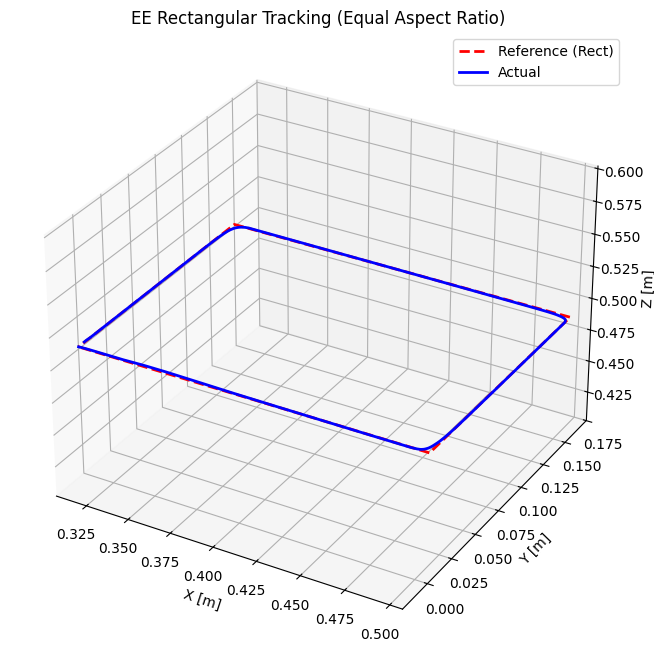

Final Pos Error (Sim): 5.1997 mm


In [5]:
# 1) Pinocchio model / data 가져오기
robot_model = pb.my_robot.pinModel.pinModel   # pinocchio.Model
robot_data  = pb.my_robot.pinModel.pinData    # pinocchio.Data

# 현재 joint 상태
q0 = pb.my_robot.q.reshape(-1)          # [nq]
nq = robot_model.nq
nv = robot_model.nv
v0 = np.zeros(nv)
x0 = np.concatenate([q0, v0])

# EE frame
ee_frame_name = "panda_ee"
ee_frame_id   = robot_model.getFrameId(ee_frame_name)

# 현재 EE pose (시작점)
pin.forwardKinematics(robot_model, robot_data, q0)
pin.updateFramePlacements(robot_model, robot_data)
M_init   = robot_data.oMf[ee_frame_id]
p_center = M_init.translation.copy()    # EE 위치 (사각형의 시작점)
R_const  = M_init.rotation.copy()       # EE 자세는 고정

print("Start EE position:", p_center)

# ==== 2) 직사각형 reference trajectory 생성 (XY 평면, z 고정) ====
# 직사각형 크기
Lx = 0.20   # X 방향 길이 [m]
Ly = 0.15   # Y 방향 길이 [m]

# 각 변당 time step 개수
T_per_edge = 125
num_edges  = 4
T          = T_per_edge * num_edges     # 총 time step 수
dt         = 0.01                        # planner time step [s]

# 꼭짓점 정의 (현재 점을 시작점으로 하는 직사각형)
# 순서: 시작 -> X축 이동 -> Y축 이동 -> -X축 이동 -> 원점 복귀
c0 = p_center
c1 = p_center + np.array([ Lx, 0.0, 0.0])
c2 = c1       + np.array([ 0.0, Ly, 0.0])
c3 = c2       + np.array([-Lx, 0.0, 0.0])
c4 = c3       + np.array([ 0.0,-Ly, 0.0])   # c0와 거의 동일

corner_points = [c0, c1, c2, c3, c4]

# 선형보간으로 reference position 리스트 만들기
ref_positions = []
for i in range(len(corner_points) - 1):
    p_start = corner_points[i]
    p_end   = corner_points[i+1]
    for k in range(T_per_edge):
        s = (k + 1) / T_per_edge
        p_k = (1.0 - s) * p_start + s * p_end
        ref_positions.append(p_k)

ref_positions = np.array(ref_positions)  # shape: [T, 3]
assert ref_positions.shape[0] == T

# reference SE3 리스트
M_ref_list = [pin.SE3(R_const, p) for p in ref_positions]

# ==== 3) [수정] PyBullet 화면에 목표 궤적 미리 그리기 (Red Lines) ====
# 기존 화면 라인 제거
p.removeAllUserDebugItems()

print("Drawing reference trajectory in PyBullet...")
for i in range(len(ref_positions) - 1):
    p.addUserDebugLine(
        lineFromXYZ=ref_positions[i],
        lineToXYZ=ref_positions[i+1],
        lineColorRGB=[1, 0, 0],  # 빨간색
        lineWidth=2.0,
        lifeTime=0,
        physicsClientId=pb.ClientId
    )

print("Solving DDP...")

# ==== 4) Crocoddyl 설정 ====
state     = crocoddyl.StateMultibody(robot_model)
actuation = crocoddyl.ActuationModelFull(state)
nu        = actuation.nu

# 비용 가중치
w_xreg   = 1e-4      # 상태 regularization
w_ureg   = 1e-4      # 입력 regularization
w_ee     = 3000.0     # EE tracking (running)
w_ee_T   = 1500.0    # EE tracking (terminal)

uResidual = crocoddyl.ResidualModelControl(state, nu)
uRegCost  = crocoddyl.CostModelResidual(state, uResidual)

runningModels = []

# 사각형 궤적을 위한 Running Models 생성
for k in range(T):
    runningCost = crocoddyl.CostModelSum(state, nu)

    # (1) State Regularization
    xref_k = np.concatenate([q0, np.zeros(nv)])
    xResidual_k = crocoddyl.ResidualModelState(state, xref_k, nu)
    xRegCost_k  = crocoddyl.CostModelResidual(state, xResidual_k)
    runningCost.addCost("xReg", xRegCost_k, w_xreg)

    # (2) Control Regularization
    runningCost.addCost("uReg", uRegCost, w_ureg)

    # (3) EE Tracking
    M_ref_k = M_ref_list[k]
    eeResidual_k = crocoddyl.ResidualModelFramePlacement(state, ee_frame_id, M_ref_k, nu)

    # Orientation 가중치 (0.2로 설정하셨는데, 너무 흔들리면 1.0으로 올리세요)
    weights = np.array([1.0, 1.0, 1.0, 0.2, 0.2, 0.2])
    activation = crocoddyl.ActivationModelWeightedQuad(weights)
    eeCost_k = crocoddyl.CostModelResidual(state, activation, eeResidual_k)
    runningCost.addCost("eeTrack", eeCost_k, w_ee)

    diffModelRunning = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCost)
    runningModel = crocoddyl.IntegratedActionModelEuler(diffModelRunning, dt)
    runningModels.append(runningModel)

# Terminal Model
terminalCostModel = crocoddyl.CostModelSum(state, nu)
M_terminal = M_ref_list[-1]

eeResidual_T = crocoddyl.ResidualModelFramePlacement(state, ee_frame_id, M_terminal, nu)
eeCost_T     = crocoddyl.CostModelResidual(state, eeResidual_T)
terminalCostModel.addCost("eeGoal", eeCost_T, w_ee_T)

# Terminal State Reg (정지 유도)
x_goal = np.concatenate([q0, np.zeros(nv)])
xResidual_T = crocoddyl.ResidualModelState(state, x_goal, nu)
xRegCost_T  = crocoddyl.CostModelResidual(state, xResidual_T)
terminalCostModel.addCost("xReg", xRegCost_T, 1e-3)

diffModelTerminal = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel)
terminalModel = crocoddyl.IntegratedActionModelEuler(diffModelTerminal, 0.0)

# Solver 실행
problem = crocoddyl.ShootingProblem(x0, runningModels, terminalModel)
solver  = crocoddyl.SolverDDP(problem)

xs_init = [x0.copy() for _ in range(T + 1)]
us_init = [np.zeros(nu) for _ in range(T)]

# solver.setCallbacks([crocoddyl.CallbackVerbose()])
solver.th_stop = 1e-6

solver.solve(xs_init, us_init, maxiter=200)
print("DDP done. Final cost:", solver.cost)

xs = solver.xs

# ==== 5) [수정] PyBullet 실행 및 실시간 궤적 그리기 (Blue Lines) ====
actual_positions = []
prev_pos = p_center.copy() # 선 그리기용 이전 위치

print("Executing trajectory...")

for x in xs:
    q = x[:nq]
    
    # 1. 로봇 이동
    pb.MoveRobot(q.reshape(-1, 1), degree=False)
    sleep(dt)

    # 2. [핵심] 실제 EE 위치 가져오기 (Ground Truth)
    # Panda 로봇의 EE 링크 인덱스 (보통 11번, URDF 확인 필요)
    link_idx = 11  
    link_state = p.getLinkState(pb.my_robot.robotId, link_idx, physicsClientId=pb.ClientId)
    curr_pos = np.array(link_state[4]) # World position
    
    actual_positions.append(curr_pos)

    # 3. 화면에 파란선 긋기
    p.addUserDebugLine(
        lineFromXYZ=prev_pos,
        lineToXYZ=curr_pos,
        lineColorRGB=[0, 0, 1], # 파란색
        lineWidth=3.0,
        lifeTime=0,
        physicsClientId=pb.ClientId
    )
    prev_pos = curr_pos

actual_positions = np.array(actual_positions)

# ==== 6) 결과 비교 그래프 (Matplotlib) ====
# ==== 6) 결과 비교 그래프 (Matplotlib) - 축 비율 고정 버전 ====
import matplotlib.pyplot as plt

fig2 = plt.figure(figsize=(10, 8))
ax2  = fig2.add_subplot(111, projection='3d')

# 데이터 플롯
ax2.plot(ref_positions[:,0],    ref_positions[:,1],    ref_positions[:,2],
         'r--', label='Reference (Rect)', linewidth=2)
ax2.plot(actual_positions[:,0], actual_positions[:,1], actual_positions[:,2],
         'b-', label='Actual', linewidth=2)

ax2.set_xlabel('X [m]')
ax2.set_ylabel('Y [m]')
ax2.set_zlabel('Z [m]')
ax2.set_title('EE Rectangular Tracking (Equal Aspect Ratio)')
ax2.legend()

# [핵심 수정] 축 비율을 데이터 범위에 맞춰 1:1:1로 설정
# X, Y, Z 중 가장 변화가 큰 축의 범위를 기준으로 모든 축의 범위를 통일합니다.
max_range = np.array([
    actual_positions[:,0].max() - actual_positions[:,0].min(),
    actual_positions[:,1].max() - actual_positions[:,1].min(),
    actual_positions[:,2].max() - actual_positions[:,2].min()
]).max() / 2.0

mid_x = (actual_positions[:,0].max() + actual_positions[:,0].min()) * 0.5
mid_y = (actual_positions[:,1].max() + actual_positions[:,1].min()) * 0.5
mid_z = (actual_positions[:,2].max() + actual_positions[:,2].min()) * 0.5

ax2.set_xlim(mid_x - max_range, mid_x + max_range)
ax2.set_ylim(mid_y - max_range, mid_y + max_range)
ax2.set_zlim(mid_z - max_range, mid_z + max_range)

ax2.grid(True)
plt.show()

# 최종 오차 출력
final_p_actual = actual_positions[-1]
final_p_ref    = ref_positions[-1]
pos_error = np.linalg.norm(final_p_actual - final_p_ref)

print(f"Final Pos Error (Sim): {pos_error * 1000:.4f} mm")

In [13]:
p.removeAllUserDebugItems()
print("All debug items removed.")

All debug items removed.


In [ ]:

from time import sleep

q_i = pb.my_robot.q
n   = q_i.size
qlist = np.zeros([n, 0])
qlist = np.concatenate((qlist, q_i), axis=1)
for _ in range(100):
    T_i = pb.my_robot.pinModel.FK(q_i)  # Use forward kinematics to get current end effector pose using joint position
    Jb_i = pb.my_robot.pinModel.Jb(q_i) # Get body Jacobian

    T_err = TransInv(T_i) @ T_goal # error in SE(3)
    lamb_err = SE32Vec(T_err)      # error in R6
 
    q_i = q_i + 0.1*np.linalg.pinv(Jb_i) @ lamb_err  # Newton-Rhapson formula, try various step sizes


    qlist = np.concatenate((qlist, q_i), axis=1)
    pb.MoveRobot(q_i, degree=False)
    sleep(0.1)
    
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(qlist.T*180/np.pi)
plt.legend(["q1", "q2", "q3", "q4", "q5", "q6", "q7"])
plt.xlabel("Step")
plt.ylabel("Joint angle (deg)")
plt.yticks([-180, -120, -60, 0, 60, 120, 180])
plt.show()

print(rad2deglist(q_i))